# Zero Truncation Extrapolation

Steps:
- use tilted field ising model
- visualization of truncation order
- determine convergence dependent on number of paulis strings
- path picture, frequency truncation
- look at coeff spectrum
- x axis pauli strings, y axis other truncation (such as min abs coeff?)

In [1]:
include("zte_recap_1_functions.jl");
global_logger(UnbufferedLogger(stdout, SubInfo));

In [2]:
function trotter_tiltedising_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64; topology = bricklayertopology(nqubits))
    target_circuit = tiltedtfitrottercircuit(nqubits, steps; topology = topology)
    target_circuit_layer  = tiltedtfitrottercircuit(nqubits, 1; topology = topology)

    theta_J = -2 * time*J/steps # -2 * J * dt
    theta_h = 2 * time*h/steps # -2 * h * dt

    theta_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z, :Z])

    theta_h_indices_Z = getparameterindices(target_circuit, PauliRotation, [:Z])
    theta_h_indices_X = getparameterindices(target_circuit, PauliRotation, [:X])

    #merge these two
    theta_h_indices = vcat(theta_h_indices_Z, theta_h_indices_X)

    theta_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z, :Z])
    theta_h_indices_layer_Z = getparameterindices(target_circuit_layer, PauliRotation, [:Z])
    theta_h_indices_layer_X = getparameterindices(target_circuit_layer, PauliRotation, [:X])

    #merge these two
    theta_h_indices_layer = vcat(theta_h_indices_layer_Z, theta_h_indices_layer_X)
    
    return trotter_ansatz_tfim(
        target_circuit,
        target_circuit_layer,
        topology,
        nqubits,
        steps,
        time,
        J,
        h,
        theta_J,
        theta_h,
        theta_J_indices,
        theta_h_indices,
        theta_J_indices_layer,
        theta_h_indices_layer
    )
end


trotter_tiltedising_setup (generic function with 1 method)

In [3]:
function discard(array, threshold)
    """
    Discard the last part of the array if the relative difference between two consecutive elements is larger than threshold.
    Used to "detect" the "phase transition", distinguishing completly wrong result because of too much truncation
    from an approximate relevant result.
    """
    for i=1:length(array)-1
        if abs(array[i]-array[i+1])/abs(array[i])>threshold
            return array[1:i]            
        end
    end
    return array
end

discard (generic function with 1 method)

## setup for tiltedtfitrottercircuit

In [4]:
#test the tilted setup
nq = 32
nl = 15

h = 1.0
J = 1.0

dt = 0.05
tilted = trotter_tiltedising_setup(nq, nl, dt*nl, J,h)

trotter_ansatz_tfim(Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [5, 6]), PauliRotation([:Z, :Z], [7, 8]), PauliRotation([:Z, :Z], [9, 10]), PauliRotation([:Z, :Z], [11, 12]), PauliRotation([:Z, :Z], [13, 14]), PauliRotation([:Z, :Z], [15, 16]), PauliRotation([:Z, :Z], [17, 18]), PauliRotation([:Z, :Z], [19, 20])  …  PauliRotation([:X], [23]), PauliRotation([:X], [24]), PauliRotation([:X], [25]), PauliRotation([:X], [26]), PauliRotation([:X], [27]), PauliRotation([:X], [28]), PauliRotation([:X], [29]), PauliRotation([:X], [30]), PauliRotation([:X], [31]), PauliRotation([:X], [32])], Gate[PauliRotation([:Z, :Z], [1, 2]), PauliRotation([:Z, :Z], [3, 4]), PauliRotation([:Z, :Z], [5, 6]), PauliRotation([:Z, :Z], [7, 8]), PauliRotation([:Z, :Z], [9, 10]), PauliRotation([:Z, :Z], [11, 12]), PauliRotation([:Z, :Z], [13, 14]), PauliRotation([:Z, :Z], [15, 16]), PauliRotation([:Z, :Z], [17, 18]), PauliRotation([:Z, :Z], [19, 20])  …  PauliRotati

## Redo ZTE fitting with the tilted Hamiltonian

In [5]:
function expvals_trunc_levels(ansatz, trunc_type; observable = observable, trunc1=-6, trunc2=-1, threshold=0.01, n=50, gamma=0.01)
    """
    Runs simulations with a certain type of truncation at different levels.
    Arguments:
    - ansatz (trotter_ansatz_tfim struct): specify the parameters of the physical system of interest.
    - trunc_type (Symbol): specify the type of truncation.
    - trunc1 (int): specify the lowest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc1.
    - trunc2 (int): specify the highest level of truncation. If the truncation level is not an integer 
        (e.g. min_abs_coeff), it will be converted to 10^trunc2.
    - threshold (float): used in the function discard to detect the "phase transition" and decide which points
        are included in the fit.
    - n (int): number of truncation levels to try out.
    - gamma (float): I forgot. Joking. Iirc used in some personalized truncations.
    """
    if trunc_type==:min_abs_coeff || trunc_type==:truncatedampingcoeff || trunc_type==:truncateprobabilistically
        #trunc1 is lower bound, trunc2 is upper bound of min_abs_coeff truncation
        # n is the number of points in intervall, threshold is for the discard criteria 
        exponents = range(trunc1, trunc2, n)
        trunc_coeffs = 10.0 .^exponents
    else
        trunc_coeffs = trunc1:-1:trunc2
    end
    expvals = Vector{Float64}()   
    terms_nbr = Vector{Float64}()   
    for trunc_value in trunc_coeffs
        if trunc_type==:truncatedampingcoeff 
            truncategamma = (pstr, coeff) -> truncatedampingcoeff(
                pstr, coeff, gamma, trunc_value
            )
            kwargs = (; customtruncfunc=truncategamma)
        elseif trunc_type==:truncateprobabilistically 
        
            log = open("log_trunc.out", "a")
            truncategamma = (pstr, coeff) -> truncateprobabilistically(
                pstr, coeff, gamma, trunc_value, log
            )
            kwargs = (; customtruncfunc=truncategamma)
        else
            kwargs = (; trunc_type => trunc_value)
        end
        #record is false by default
        expval_t, terms_t = trotter_time_evolution(ansatz;observable = observable, return_fmt="countterms", kwargs...)
        push!(expvals, expval_t)
        push!(terms_nbr, terms_t)
    end
    clean_expvals = discard(expvals, threshold)
    clean_trunc_coeffs = trunc_coeffs[1:length(clean_expvals)]
    clean_terms_nbr = terms_nbr[1:length(clean_expvals)]

    return clean_terms_nbr, clean_trunc_coeffs, clean_expvals, terms_nbr, trunc_coeffs, expvals
end

expvals_trunc_levels (generic function with 1 method)

In [6]:
function correcting_single_truncations(ansatz, trunc_type::Vector{Symbol}=[:min_abs_coeff]; observable = nothing, 
    trunc1=[-6], trunc2=[-1], threshold=0.1e-3, abs_threshold=1e-6, plotting=false, n=50, gamma=0.01, mode="avg", exact = false)
    """
    Performs the simulations (calling expvals_trunc_levels) and correct the value. Can do some fancy plotting.
    Can either fit exponentially or linearly the data (mode="exp" or "lin") or average (mode="avg").
    """
    corrected_expvals = Dict()
    clean_trunc_coeffs = Dict()
    clean_terms_nbr = Dict()
    clean_expvals = Dict()
    trunc_coeffs = Dict()
    terms_nbr = Dict()
    expvals = Dict()

    if exact
        exact_expval = trotter_time_evolution(ansatz; observable = observable, min_abs_coeff = 1e-6, record = false)
    end 

    for (t, t1, t2) in zip(trunc_type, trunc1, trunc2)
        # println("$t $t1 $t2")
        clean_terms_nbr_tmp, clean_trunc_coeffs_tmp, clean_expvals_tmp, terms_nbr_tmp, trunc_coeffs_tmp, expvals_tmp = 
            expvals_trunc_levels(ansatz, t; observable = observable, trunc1=t1, trunc2=t2, threshold=threshold, n=n, gamma=gamma)
        println("clean_terms_nbr_tmp: ", clean_terms_nbr_tmp)
        println("clean_trunc_coeffs_tmp: ", clean_trunc_coeffs_tmp)
        println("clean_expvals_tmp: ", clean_expvals_tmp)
        
        # new filter: remove expvals below abs_threshold
        mask = clean_expvals_tmp .>= abs_threshold
        xdata = clean_terms_nbr_tmp[mask]
        println("xdata: ", xdata)
        ydata = clean_expvals_tmp[mask]
        println("ydata: ", ydata)
        xfit = range(minimum(xdata), maximum(xdata), length=200)

        if mode=="exp"

            modelexp(x,p) = p[1] .+ p[2] .* exp.(-p[3] .* x)
            p0 = [ydata[end], ydata[1] - ydata[end], 0.01]  # smaller initial rate

            fit = curve_fit(modelexp, xdata, ydata, p0)
            corrected_expval = modelexp(Inf, fit.param)
            println("corrected_expval: ", corrected_expval)
            yfit = modelexp.(xfit, Ref(fit.param))
            println("init params", p0)
            println("exp fit params: ", fit.param)

        # this was a bad idea
        elseif mode=="lin"
            modellin(x, p) = p[1] .+ p[2] .* x
            p0 = [ydata[end], (ydata[end]-ydata[1])]
            fit = curve_fit(modellin, xdata, ydata, p0)
            corrected_expval = modellin(Inf, fit.param)
            yfit = modellin.(xfit, Ref(fit.param))

        elseif mode=="avg"
            corrected_expval = mean(ydata)
        else
            println("what's mode=$mode? Average instead.")
            corrected_expval = mean(ydata)
        end

        #t is the truncation type
        corrected_expvals[t] = corrected_expval
        trunc_coeffs[t] = clean_trunc_coeffs_tmp
        clean_trunc_coeffs[t] = clean_trunc_coeffs_tmp[mask]
        terms_nbr[t] = terms_nbr_tmp
        clean_terms_nbr[t] = xdata
        clean_expvals[t] = ydata
        expvals[t] = expvals_tmp
    
        if exact
            println("exact_expval: ", exact_expval) #only print 2 digits after point
            println("corrected_expval: ", corrected_expval)
            println(format("absolute error corrected: {:.2e}", abs(exact_expval - corrected_expval) ) ) 
            println(format("absolute error of lowest truncation included: {:.2e}", abs(exact_expval - clean_expvals_tmp[1]) ))

            abs_error_last = abs(exact_expval - clean_expvals_tmp[1])
            abs_error_corr = abs(exact_expval - corrected_expval)
        end 
        
        if plotting
            mask_tmp = [terms_nbr_tmp[i]!=terms_nbr_tmp[i+1] for i in 1:length(terms_nbr_tmp)-1]
            push!(mask_tmp, true)
            
            expvals_tmp[expvals_tmp .== 0] .= 1e-16
            ydata[ydata .== 0] .= 1e-16
            terms_nbr_tmp[terms_nbr_tmp .== 0] .= 1e-1
            xdata[xdata .== 0] .= 1e-1
            
            p = plot(terms_nbr_tmp[mask_tmp], expvals_tmp[mask_tmp], markershape=:circle, label="Data not included\nin the fit", legend=:topright)
            
            mask_data = [xdata[i]!=xdata[i+1] for i in 1:length(xdata)-1]
            push!(mask_data, true)
            scatter!(xdata[mask_data], ydata[mask_data], markershape=:circle, label="Data included\nin the fit")
            if mode=="lin" || mode=="exp"
                plot!(xfit, yfit, label="ZTE fit $mode", lw=3, ls=:dash)
            else
                plot!(xfit, ones(200)*corrected_expval, line=:dash, lw=3, label="Averaged value")
            end

            xlabel!("number of terms in the Pauli sum")
            ylabel!("expectation value")
            title!("$(String(t)) (fit $mode)")
            display(p)
        end
    end
    
    return corrected_expvals, clean_trunc_coeffs, clean_expvals, trunc_coeffs, expvals
end


correcting_single_truncations (generic function with 2 methods)

### Avg and Exp truncations

clean_terms_nbr_tmp: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
clean_trunc_coeffs_tmp: [0.0001, 0.00012067926406393288, 0.00014563484775012445, 0.00017575106248547912, 0.00021209508879201905, 0.0002559547922699536, 0.00030888435964774815, 0.00037275937203149417]
clean_expvals_tmp: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
xdata: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
ydata: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
exact_expval: 0.09285850603017355
corrected_expval: 0.08911830194366642
absolute error corrected: 3.74e-03
absolute error of lowest truncation included: 1.91e-03


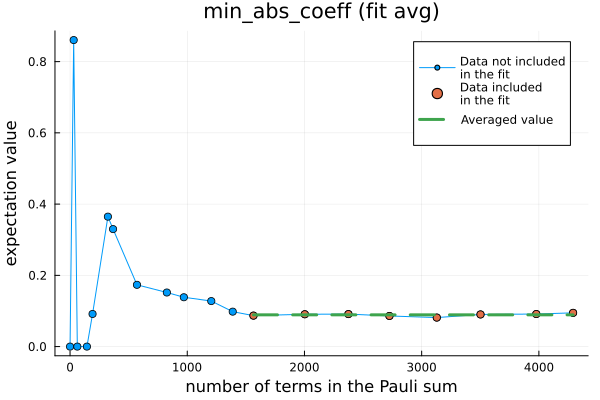

In [9]:
correcting_single_truncations(tilted, [:min_abs_coeff]; trunc1=[-4], trunc2=[0], threshold = 1e-1, plotting=true, mode="avg", exact = true);

clean_terms_nbr_tmp: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
clean_trunc_coeffs_tmp: [0.0001, 0.00012067926406393288, 0.00014563484775012445, 0.00017575106248547912, 0.00021209508879201905, 0.0002559547922699536, 0.00030888435964774815, 0.00037275937203149417]
clean_expvals_tmp: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
xdata: [4292.0, 3978.0, 3502.0, 3129.0, 2725.0, 2375.0, 2003.0, 1565.0]
ydata: [0.09476965927217865, 0.09141667171524558, 0.09025633665616796, 0.08149236183945943, 0.08601954965885189, 0.09125814515665139, 0.09077108993207555, 0.08696260131870089]
corrected_expval: 0.08911830194359069
init params[0.08696260131870089, 0.007807057953477761, 0.01]
exp fit params: [0.08911830194359069, 0.007094865305577353, 0.018186256170104803]
exact_expval: 0.09285850603017355
corrected_expval: 0.08911830194359069
absolute error corrected:

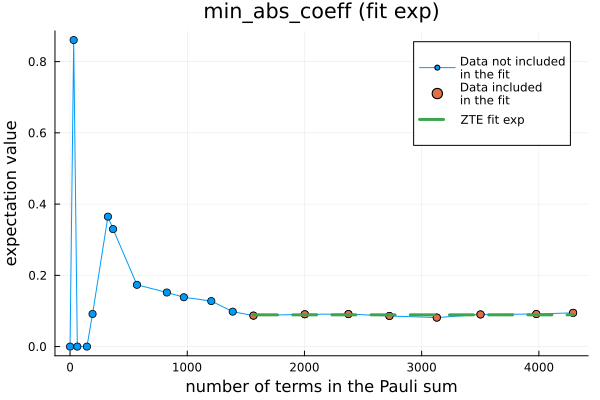

In [10]:
correcting_single_truncations(tilted, [:min_abs_coeff]; trunc1=[-4], trunc2=[0], threshold = 1e-1, plotting=true, mode="exp", exact = true);

- fit only before convergence
- then exp makes no sense because we need convergence already to fit it
- average would assume our values fluctuate equally around the target expecatation value
- comp effort should be lower than computing a lower truncation order (exponentially more terms per truncation order, if we have a factor n of terms of higher order, is this faster than running one simulation at a lower truncation order?)